# Topological Data Analysis (TDA) of PDGFR-β+ labeled nuclei (FISH).

## Preview

This notebook reports the topological data analysis (TDA) for PDGFR-β+ nuceli (labeled with fluorescence in situ hybridization) in three ROIs of the ischemic hemisphere. Please note that this notebook runs Python code. 

**Parent dataset:** PDGFR-β(FISH) stained ischemic hemispheres imaged at 10x (with stitching). We took regions of interest (ROIs) from three different areas in the injure cortex/striatum to quantify PDGFR-β expression. Samples are grouped at 0 (Sham), and 14 days post-ischemia (DPI). The raw images and pre-processing scripts (if applicable) are available at the Zenodo repository (10.5281/zenodo.10553084) under the name `Widefield_10x_ROIs_KO_Fish_Pdgfrb.zip`. Please note that we excluded mice `KL31` because of an inefficient staining (the section dried during the staining procedure).

**Working dataset**: The `Data_Processed/Widefield_10x_ROIs_KO_Fish_Pdgfrb/Widefield_10x_ROIs_KO_Fish_Pdgfrb_AreaInt.csv`data frame containing the individual xy coordinates of PDGFR-β+ cells generated in a Quarto [notebook](https://github.com/elalilab/Stroke_PDGFR-B_Reactivity/blob/main/Widefield_10x_Ipsilateral_KO_Fish_Pdgfrb.qmd).

**Note:** This notebook runs using python code.

## Load required libraries

We import the required Python libraries.

In [37]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import csv

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Circle

import gudhi as gd
from gudhi import RipsComplex, plot_persistence_diagram
from gudhi import bottleneck_distance
from gudhi.wasserstein import wasserstein_distance

import itertools
from ripser import ripser
from persim import plot_diagrams
from random import choices
from scipy.spatial import ConvexHull
from collections import defaultdict  

## Load and handle the dataset

In [5]:
# Load the dataset
file_path = 'Data_Processed/Widefield_10x_ROIs_KO_Fish_Pdgfrb/Widefield_10x_ROIs_KO_Fish_Pdgfrb_AreaInt.csv'
data = pd.read_csv(file_path)

# Display the first few rows to check the data
data.head()


,Area,Intensity,x-coord,y-coord,MouseID,DPI,Genotype,Section
0,156,65.310231,26.653846,5.429487,KL26,14D,WT,S1
1,65,19.471275,36.738462,8.984615,KL26,14D,WT,S1
2,104,49.192050,168.807692,31.288462,KL26,14D,WT,S1
3,98,36.100435,95.336735,36.091837,KL26,14D,WT,S1
4,235,88.383765,249.225532,37.953191,KL26,14D,WT,S1


We then filter the 14D data

In [7]:
# Filter the data
filtered_data = data[data['DPI'] == '14D']

# Display the first few rows of the filtered data
filtered_data.head()

# Check the data types and any missing values
filtered_data.info()

# Check for unique values in 'MouseID', 'Section', and 'genotype'
print("Unique MouseIDs:", filtered_data['MouseID'].unique())
print("Unique Sections:", filtered_data['Section'].unique())
print("Unique Genotypes:", filtered_data['Genotype'].unique())


<class 'pandas.core.frame.DataFrame'>
Index: 5588 entries, 0 to 5918
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Area       5588 non-null   int64  
 1   Intensity  5588 non-null   float64
 2   x-coord    5588 non-null   float64
 3   y-coord    5588 non-null   float64
 4   MouseID    5588 non-null   object 
 5   DPI        5588 non-null   object 
 6   Genotype   5588 non-null   object 
 7   Section    5588 non-null   object 
dtypes: float64(3), int64(1), object(4)
memory usage: 392.9+ KB
Unique MouseIDs: ['KL26' 'KL27' 'KL28' 'KL29' 'KL32' 'KL34' 'KL36' 'KL39' 'KL48' 'KL49'
 'KL50' 'KL52' 'KL53' 'KL54' 'KL56' 'KL57']
Unique Sections: ['S1' 'S2' 'S3']
Unique Genotypes: ['WT' 'KO']


We group the datasets by animals and sections

In [8]:
# Group the filtered dataset by MouseID and Section, then extract the point clouds
point_clouds_by_mouse_section = filtered_data.groupby(['MouseID', 'Section']).apply(lambda df: df[['x-coord', 'y-coord']].values).to_dict()


## Calculate Vietoris-Rips Complex

For information on this aspect please refer to the following Jupyther [notebook](https://github.com/elalilab/Stroke_PDGFR-B_Reactivity/blob/main/Widefield_20x_ROIs_Pdgfrb_TDA.ipynb)

In [14]:
def calculate_vietoris_rips_complex(point_cloud, max_dim, max_radius):
    """
    Calculate the Vietoris-Rips complex for a given point cloud.
    
    Parameters:
    - point_cloud: numpy array of shape (n_points, n_dimensions) representing the point cloud.
    - max_dim: int, the maximal dimension of the simplices in the Vietoris-Rips complex.
    - max_radius: float, the maximal radius for simplices in the Vietoris-Rips complex.
    
    Returns:
    - simplex_tree: a GUDHI SimplexTree object representing the Vietoris-Rips complex.
    """
    rips_complex = gd.RipsComplex(points=point_cloud, max_edge_length=max_radius)
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=max_dim)
    return simplex_tree

# Parameters for Vietoris-Rips complex calculation
max_dim = 3
max_radius = 50

# Calculate Vietoris-Rips complexes for each section of each mouse
vietoris_rips_complexes = {}
for (mouse_id, section), point_cloud in point_clouds_by_mouse_section.items():
    key = (mouse_id, section)  # Use a tuple of MouseID and Section as the key
    vietoris_rips_complexes[key] = calculate_vietoris_rips_complex(point_cloud, max_dim, max_radius)


We plot a sample point cloud

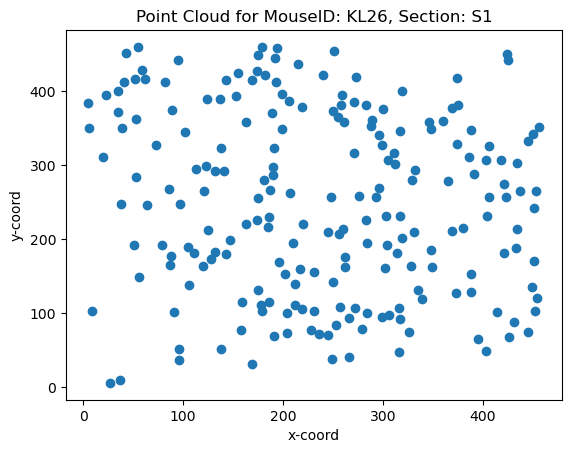

In [16]:
# Plotting a sample point cloud for one 'MouseID' and 'Section'
sample_key = list(point_clouds_by_mouse_section.keys())[0]
sample_point_cloud = point_clouds_by_mouse_section[sample_key]

plt.scatter(sample_point_cloud[:, 0], sample_point_cloud[:, 1])
plt.xlabel('x-coord')
plt.ylabel('y-coord')
plt.title(f"Point Cloud for MouseID: {sample_key[0]}, Section: {sample_key[1]}")
plt.show()


Then, we save the point clouds in a designated folder:

## Save static Vietoris-rips complexes

In [18]:
def plot_vietoris_rips_complex(point_cloud, simplex_tree, filename, save_dir, x_range=None, y_range=None):
    """
    Plot and save the Vietoris-Rips complex for a given 2D point cloud, with specified x and y axis ranges.

    Parameters:
    - point_cloud: numpy array of shape (n_points, 2) representing the 2D point cloud.
    - simplex_tree: a GUDHI SimplexTree object representing the Vietoris-Rips complex.
    - filename: str, the name of the file to save the image.
    - save_dir: str, directory to save the image.
    - x_range: tuple, the range for the x-axis (optional).
    - y_range: tuple, the range for the y-axis (optional).
    """
    fig, ax = plt.subplots(figsize=(6, 4))
    
    # Plot points
    ax.scatter(point_cloud[:, 0], point_cloud[:, 1], c='black', s=20, alpha=0.8)
    
    # Plot edges
    edges = []
    for simplex in simplex_tree.get_skeleton(2):  # Get up to 2-simplices (edges)
        if len(simplex[0]) == 2:  # Edges
            p1, p2 = point_cloud[simplex[0][0]], point_cloud[simplex[0][1]]
            edges.append([p1, p2])
    lc = LineCollection(edges, colors='green', linewidths=1, alpha=0.7)
    ax.add_collection(lc)
    
    # Adjust plot settings
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    if x_range is not None:
        ax.set_xlim(x_range)
    if y_range is not None:
        ax.set_ylim(y_range)
    
    plt.tight_layout()
    
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    plt.savefig(os.path.join(save_dir, f"{filename}.png"))
    plt.close()

    
    # Directory to save the images
output_dir = "D:/Research/Stroke_PDGFR-B_Reactivity/Images/Widefield_10x_ROIs_KO_Fish_Pdgfrb_TDA/VietorisRips_Static"
#x_range = (0, 500)  # Example x-axis range, update based on your data
#y_range = (0, 550)  # Example y-axis range, update based on your data

# Generate and save plots for each section of each mouse
for (mouse_id, section), simplex_tree in vietoris_rips_complexes.items():
    filename = f"{mouse_id}_{section}_VietorisRips"
    point_cloud = point_clouds_by_mouse_section[(mouse_id, section)]
    plot_vietoris_rips_complex(point_cloud, simplex_tree, filename, output_dir, x_range, y_range)


## Save animated Vietoris-rips complexes

In [20]:
def animate_vietoris_rips_mp4(point_cloud, simplex_tree, filename, save_dir, max_radius, step_size=1):
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.scatter(point_cloud[:, 0], point_cloud[:, 1], c='black', s=20, alpha=0.8)

    def update(threshold):
        ax.cla()  # Clear current plot details
        ax.scatter(point_cloud[:, 0], point_cloud[:, 1], c='black', s=10, alpha=0.7)
        edges = []
        for simplex in simplex_tree.get_skeleton(2):
            if simplex[1] <= threshold:
                if len(simplex[0]) == 2:  # Edges
                    p1, p2 = point_cloud[simplex[0][0]], point_cloud[simplex[0][1]]
                    edges.append([p1, p2])
        lc = LineCollection(edges, colors='green', alpha=0.7)
        ax.add_collection(lc)
        
        ax.set_title(f"Threshold: {threshold:.2f}", fontsize=20)
        ax.set_xlabel('X', fontsize=20, labelpad=15)
        ax.set_ylabel('Y', fontsize=20, labelpad=15)
        ax.tick_params(axis='both', which='major', labelsize=20)
        ax.axis('equal')

    ani = FuncAnimation(fig, update, frames=np.arange(0, max_radius, step_size), blit=False)
    ani_file = os.path.join(save_dir, f"{filename}_Animation.mp4")
    ani.save(ani_file, writer='ffmpeg', fps=2, extra_args=['-vcodec', 'libx264'])

    plt.close()
    return ani_file

# Directory to save the animations
output_dir = "D:/Research/Stroke_PDGFR-B_Reactivity/Images/Widefield_10x_ROIs_KO_Fish_Pdgfrb_TDA/VietorisRips_Animated"  # Update this path
max_radius = 100  # Adjust as necessary
step_size = 100  # Adjust as necessary

# Generate and save animations for each section of each mouse
for (mouse_id, section), simplex_tree in vietoris_rips_complexes.items():
    filename = f"{mouse_id}_{section}_VietorisRips"
    point_cloud = point_clouds_by_mouse_section[(mouse_id, section)]
    ani_file = animate_vietoris_rips_mp4(point_cloud, simplex_tree, filename, output_dir, max_radius, step_size)
    print(f"Saved animation: {ani_file}")


Saved animation: D:/Research/Stroke_PDGFR-B_Reactivity/Images/Widefield_10x_ROIs_KO_Fish_Pdgfrb_TDA/VietorisRips_Animated\KL26_S1_VietorisRips_Animation.mp4
Saved animation: D:/Research/Stroke_PDGFR-B_Reactivity/Images/Widefield_10x_ROIs_KO_Fish_Pdgfrb_TDA/VietorisRips_Animated\KL26_S2_VietorisRips_Animation.mp4
Saved animation: D:/Research/Stroke_PDGFR-B_Reactivity/Images/Widefield_10x_ROIs_KO_Fish_Pdgfrb_TDA/VietorisRips_Animated\KL26_S3_VietorisRips_Animation.mp4
Saved animation: D:/Research/Stroke_PDGFR-B_Reactivity/Images/Widefield_10x_ROIs_KO_Fish_Pdgfrb_TDA/VietorisRips_Animated\KL27_S1_VietorisRips_Animation.mp4
Saved animation: D:/Research/Stroke_PDGFR-B_Reactivity/Images/Widefield_10x_ROIs_KO_Fish_Pdgfrb_TDA/VietorisRips_Animated\KL27_S2_VietorisRips_Animation.mp4
Saved animation: D:/Research/Stroke_PDGFR-B_Reactivity/Images/Widefield_10x_ROIs_KO_Fish_Pdgfrb_TDA/VietorisRips_Animated\KL27_S3_VietorisRips_Animation.mp4
Saved animation: D:/Research/Stroke_PDGFR-B_Reactivity/Ima

## Generate point clouds

Now, we generate point clouds to perform pcalculations of persistent homology. First, we define the groups to generate the point clods.

In [21]:
# Group the filtered dataset by MouseID and Section, then extract the point clouds
point_clouds_by_group = filtered_data.groupby(['MouseID', 'Section']).apply(
    lambda df: df[['x-coord', 'y-coord']].values
).to_dict()

# Check if the point_clouds_by_group dictionary is empty
if not point_clouds_by_group:
    print("The point_clouds_by_group dictionary is empty.")
else:
    print("Point clouds loaded:", len(point_clouds_by_group))
    
    # Inspect the first few items to ensure they're structured correctly
    for key, value in list(point_clouds_by_group.items())[:5]:
        print(key, value.shape)


Point clouds loaded: 47
('KL26', 'S1') (211, 2)
('KL26', 'S2') (153, 2)
('KL26', 'S3') (236, 2)
('KL27', 'S1') (74, 2)
('KL27', 'S2') (188, 2)


We generate and save the point clouds

In [22]:
def save_point_clouds_as_npy(point_clouds_by_group, data_directory):
    """
    Saves point clouds to .npy files in the specified directory.
    
    Parameters:
        point_clouds_by_group (dict): Dictionary with keys as identifiers 
            (e.g., ('MouseID', 'Section')) and values as numpy arrays representing point clouds.
        data_directory (str): Path to the directory where .npy files will be saved.
    """
    # Ensure the directory exists
    if not os.path.exists(data_directory):
        os.makedirs(data_directory)
    
    # Iterate through the point clouds and save each as an .npy file
    for identifier, point_cloud in point_clouds_by_group.items():
        # Create a filename from the identifier
        filename = "_".join(map(str, identifier)) + ".npy"
        filepath = os.path.join(data_directory, filename)
        np.save(filepath, point_cloud)
    
    print("Point clouds saved as .npy files.")
    
    # Directory to save the point clouds
data_directory = "PointClouds/Widefield_10x_ROIs_KO_Fish_Pdgfrb/"  # Update this path

# Call the function with your data and desired save location
save_point_clouds_as_npy(point_clouds_by_group, data_directory)



Point clouds saved as .npy files.


## Calculate persistence homology

First, we disable latex to aviod problems in plotting

In [23]:
plt.rcParams['text.usetex'] = False

Next, we define an execute a function for the calculation of persistence homology. 

In [25]:
def process_npy_for_persistence_diagrams(data_directory, save_directory, save_diag_directory, img_size=(6, 6), x_range=None, y_range=None):
    """
    Process .npy files to compute and save persistence diagrams.

    Parameters:
    - data_directory: str, directory containing the .npy files.
    - save_directory: str, directory to save the persistence diagram images.
    - save_diag_directory: str, directory to save the persistence diagram data.
    - img_size: tuple, size of the output images.
    - x_range: tuple, the range for the x-axis (optional).
    - y_range: tuple, the range for the y-axis (optional).
    """
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)
    if not os.path.exists(save_diag_directory):
        os.makedirs(save_diag_directory)
    
    npy_files = [f for f in os.listdir(data_directory) if f.endswith('.npy')]
    
    for file in npy_files:
        points_array = np.load(os.path.join(data_directory, file))
        
        # Compute persistence diagrams using Ripser
        diagrams = ripser(points_array, maxdim=1)['dgms']
        
        # Save persistence diagram data
        for dim, diag in enumerate(diagrams):
            diag_filename = os.path.splitext(file)[0] + f"_persistence_diag_dim{dim}.npy"
            np.save(os.path.join(save_diag_directory, diag_filename), diag)
        
        # Plot and save persistence diagrams
        fig, ax = plt.subplots(figsize=img_size)
        plot_diagrams(diagrams, show=False, ax=ax)
        ax.set_title("")
        ax.set_xlabel('Birth', fontsize=25)
        ax.set_ylabel('Death', fontsize=25)
        ax.tick_params(axis='both', which='major', labelsize=25)
        
        legend = ax.legend()
        if legend:
            for label in legend.get_texts():
                label.set_fontsize(20)
        
        plt.tight_layout()
        
        if x_range is not None:
            ax.set_xlim(x_range)
        if y_range is not None:
            ax.set_ylim(y_range)
        
        filename = os.path.splitext(file)[0] + "_persistence_diagram.png"
        fig.savefig(os.path.join(save_directory, filename))
        plt.close()
    
    print(f"Persistence diagrams saved to {save_directory}.")
    print(f"Persistence diagrams data saved to {save_diag_directory}.")
    
    # Directory containing the .npy point cloud files
data_directory = "PointClouds/Widefield_10x_ROIs_KO_Fish_Pdgfrb/"  # Update this path

# Directory to save the persistence diagram images
save_directory = "D:/Research/Stroke_PDGFR-B_Reactivity/Images/Widefield_10x_ROIs_KO_Fish_Pdgfrb_TDA/PersistenceDiagrams"  # Update this path

# Directory to save the persistence diagram data
save_diag_directory = "Data_Raw/Widefield_10x_ROIs_KO_Fish_Pdgfrb_TDA/PersistenceDiagrams"  # Update this path

# Optional: Set x and y axis ranges
# x_range = (0, 500)  
# y_range = (0, 500)

# Call the function to process .npy files for persistence diagrams
process_npy_for_persistence_diagrams(data_directory, save_directory, save_diag_directory, img_size=(6, 6), x_range=None, y_range=None)



Persistence diagrams saved to D:/Research/Stroke_PDGFR-B_Reactivity/Images/Widefield_10x_ROIs_KO_Fish_Pdgfrb_TDA/PersistenceDiagrams.
Persistence diagrams data saved to Data_Raw/Widefield_10x_ROIs_KO_Fish_Pdgfrb_TDA/PersistenceDiagrams/.


## Calculate bett curves

### For 0D homology

We load the genotype mapping from our .csv file: 

In [57]:
def load_genotype_mapping(csv_path):
    df = pd.read_csv(csv_path)
    mouse_id_to_genotype = dict(zip(df['MouseID'], df['Genotype']))
    return mouse_id_to_genotype

csv_path = "Data_Processed/Widefield_10x_ROIs_KO_Fish_Pdgfrb/Widefield_10x_ROIs_KO_Fish_Pdgfrb_AreaInt.csv"  # Update this path
mouse_id_to_genotype = load_genotype_mapping(csv_path)


Next, we load the persistence diagrams for 0D homology

In [66]:
def load_persistence_diagrams(dim0_path, mouse_id_to_genotype):
    files = [f for f in os.listdir(dim0_path) if 'dim0' in f]
    data = {}
    for file in files:
        parts = file.split('_')
        mouse_id, section = parts[0], parts[1]
        genotype = mouse_id_to_genotype.get(mouse_id, 'Unknown')
        diagram = np.load(os.path.join(dim0_path, file))
        key = (genotype, mouse_id, section)
        data[key] = diagram
    return data

dim0_path = "Data_Raw/Widefield_10x_ROIs_KO_Fish_Pdgfrb_TDA/PersistenceDiagrams"  # Update this path
dim0_data = load_persistence_diagrams(dim0_path, mouse_id_to_genotype)


We calculate the Betti curves for 0D homology.

In [87]:
def compute_betti_0_curve(persistence_diagram, max_filtration_value, n_steps):
    betti_0_curve = []
    filtration_values = np.linspace(0, max_filtration_value, n_steps)
    for value in filtration_values:
        betti_0 = sum(1 for point in persistence_diagram if point[0] <= value and (point[1] > value or point[1] == float('inf')))
        betti_0_curve.append(betti_0)

    # Normalize the curve to start at 1
    if betti_0_curve[0] != 0:  # Ensure there is no division by zero
        initial_value = betti_0_curve[0]
        normalized_betti_0_curve = [b / initial_value for b in betti_0_curve]
    else:
        # Handle the case where the initial value is 0
        normalized_betti_0_curve = betti_0_curve

    return normalized_betti_0_curve

n_steps = 100
max_filtration_value = 100
betti_0_curves = {key: compute_betti_0_curve(diagram, max_filtration_value, n_steps) for key, diagram in dim0_data.items()}


Before plotting, we aggregate the Betti curves by genotype. 

In [89]:
aggregated_curves_by_genotype = defaultdict(list)
for (genotype, mouse_id, section), curve in betti_0_curves.items():
    aggregated_curves_by_genotype[genotype].append(curve)

# Print some intermediate results to verify aggregation
for genotype, curves in aggregated_curves_by_genotype.items():
    print(f"Genotype: {genotype}, Number of curves: {len(curves)}")

# Calculate the mean and standard deviation of the Betti-0 curves for each genotype
mean_curves_by_genotype = {genotype: np.mean(curves, axis=0) for genotype, curves in aggregated_curves_by_genotype.items()}
std_curves_by_genotype = {genotype: np.std(curves, axis=0) for genotype, curves in aggregated_curves_by_genotype.items()}


Genotype: WT, Number of curves: 20
Genotype: KO, Number of curves: 27


Now, we plot and save the Betti curves. 

Saved Betti-0 curve plot at Plots/Widefield_10x_ROIs_KO_Fish_Pdgfrb\Betti0_Curves_KO_WT.png


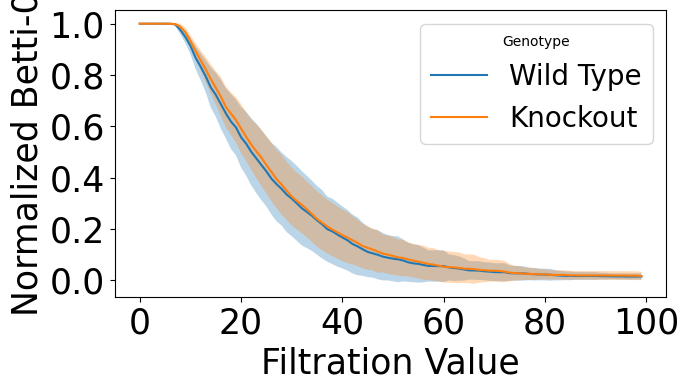

In [96]:
# Define custom legend labels
legend_labels = {
    'WT': 'Wild Type',
    'KO': 'Knockout'
}

def plot_aggregated_betti_curves(mean_curves_by_genotype, std_curves_by_genotype, save_directory, legend_labels):
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)
    
    plt.figure(figsize=(7, 4))
    
    for genotype, mean_curve in mean_curves_by_genotype.items():
        std_curve = std_curves_by_genotype[genotype]
        label = legend_labels.get(genotype, genotype)  # Get custom label or use the genotype as default
        plt.plot(mean_curve, label=label)
        plt.fill_between(range(len(mean_curve)), mean_curve - std_curve, mean_curve + std_curve, alpha=0.3)
    
    plt.xlabel("Filtration Value", fontsize=25)
    plt.ylabel("Normalized Betti-0", fontsize=25)
    plt.xticks(fontsize=25)
    plt.yticks(fontsize=25)
    plt.legend(title="Genotype", fontsize=20)
    plt.title("", fontsize=25)
    plt.tight_layout()

    plot_path = os.path.join(save_directory, "Betti0_Curves_KO_WT.png")
    plt.savefig(plot_path)
    print(f"Saved Betti-0 curve plot at {plot_path}")
    
    plt.show()
    plt.close()


save_directory = "Plots/Widefield_10x_ROIs_KO_Fish_Pdgfrb"  # Update this path
plot_aggregated_betti_curves(mean_curves_by_genotype, std_curves_by_genotype, save_directory, legend_labels)


In [97]:
### For 1D homology

In [98]:
def load_persistence_diagrams(dim1_path, mouse_id_to_genotype):
    files = [f for f in os.listdir(dim1_path) if 'dim1' in f]
    data = {}
    for file in files:
        parts = file.split('_')
        mouse_id, section = parts[0], parts[1]
        genotype = mouse_id_to_genotype.get(mouse_id, 'Unknown')
        diagram = np.load(os.path.join(dim1_path, file))
        key = (genotype, mouse_id, section)
        data[key] = diagram
    return data

dim1_path = "Data_Raw/Widefield_10x_ROIs_KO_Fish_Pdgfrb_TDA/PersistenceDiagrams"  # Update this path
dim1_data = load_persistence_diagrams(dim1_path, mouse_id_to_genotype)


Compute the Betti curves for 1D homology:

In [102]:
def compute_betti_1_curve(persistence_diagram, max_filtration_value, n_steps):
    betti_1_curve = []
    filtration_values = np.linspace(0, max_filtration_value, n_steps)
    for value in filtration_values:
        betti_1 = sum(1 for point in persistence_diagram if point[0] <= value and (point[1] > value or point[1] == float('inf')))
        betti_1_curve.append(betti_1)
    return betti_1_curve

n_steps = 100
max_filtration_value = 200
betti_1_curves = {key: compute_betti_1_curve(diagram, max_filtration_value, n_steps) for key, diagram in dim1_data.items()}


WE aggregate the curves by genotype

In [103]:
aggregated_curves_by_genotype = defaultdict(list)
for (genotype, mouse_id, section), curve in betti_1_curves.items():
    aggregated_curves_by_genotype[genotype].append(curve)

# Print some intermediate results to verify aggregation
for genotype, curves in aggregated_curves_by_genotype.items():
    print(f"Genotype: {genotype}, Number of curves: {len(curves)}")

# Calculate the mean and standard deviation of the Betti-1 curves for each genotype
mean_curves_by_genotype = {genotype: np.mean(curves, axis=0) for genotype, curves in aggregated_curves_by_genotype.items()}
std_curves_by_genotype = {genotype: np.std(curves, axis=0) for genotype, curves in aggregated_curves_by_genotype.items()}


Genotype: WT, Number of curves: 20
Genotype: KO, Number of curves: 27


And finally, we plot the Betti curves:

Saved Betti-1 curve plot at Plots/Widefield_10x_ROIs_KO_Fish_Pdgfrb\Betti1_Curves_KO_WT.png


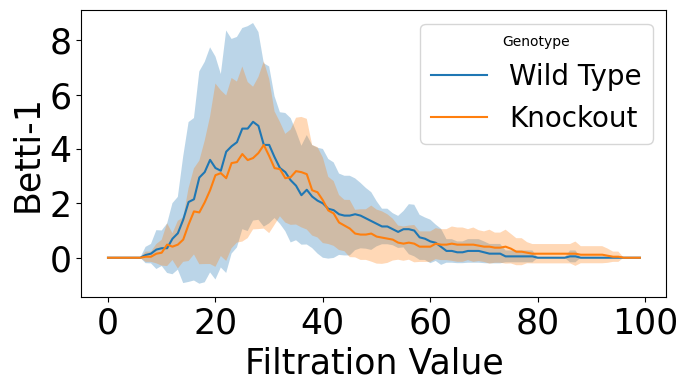

In [106]:
def plot_aggregated_betti_curves(mean_curves_by_genotype, std_curves_by_genotype, save_directory, legend_labels):
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)
    
    plt.figure(figsize=(7, 4))
    
    for genotype, mean_curve in mean_curves_by_genotype.items():
        std_curve = std_curves_by_genotype[genotype]
        label = legend_labels.get(genotype, genotype)  # Get custom label or use the genotype as default
        plt.plot(mean_curve, label=label)
        plt.fill_between(range(len(mean_curve)), mean_curve - std_curve, mean_curve + std_curve, alpha=0.3)
    
    plt.xlabel("Filtration Value", fontsize=25)
    plt.ylabel("Betti-1", fontsize=25)
    plt.xticks(fontsize=25)
    plt.yticks(fontsize=25)
    plt.legend(title="Genotype", fontsize=20)
    plt.title("", fontsize=25)
    plt.tight_layout()

    plot_path = os.path.join(save_directory, "Betti1_Curves_KO_WT.png")
    plt.savefig(plot_path)
    print(f"Saved Betti-1 curve plot at {plot_path}")
    
    plt.show()
    plt.close()

# Define custom legend labels
legend_labels = {
    'WT': 'Wild Type',
    'KO': 'Knockout'
}

save_directory = "Plots/Widefield_10x_ROIs_KO_Fish_Pdgfrb"  # Update this path
plot_aggregated_betti_curves(mean_curves_by_genotype, std_curves_by_genotype, save_directory, legend_labels)
